In [18]:
import os
import cv2
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from typing import Literal
from torchvision import models
import matplotlib.pyplot as plt
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

In [19]:
def load_img_paths(dir_path):

    img_paths = []
    for img in os.listdir(dir_path):
        img_paths.append(os.path.join(dir_path,img))
    return img_paths

In [20]:
marigold = load_img_paths('/content/dataset/marigold')
sunflower = load_img_paths('/content/dataset/sunflower')
# marigold = load_img_paths('dataset\marigold')
# sunflower = load_img_paths('dataset\sunflower')

marigold = list(zip(marigold,[0]*len(marigold)))
sunflower = list(zip(sunflower,[1]*len(sunflower)))

dataset = marigold+sunflower

# train test split while maintaining class balance
_,labels = zip(*dataset)
train , test = train_test_split(dataset,test_size=0.2,stratify=labels)

In [21]:
class flowerDataset(Dataset):
    # def __init__(self,data,img_size=(225,225),device=torch.device('cpu')):
    def __init__(self,data,img_size=(224,224),device=torch.device('cpu')):
        super().__init__()
        self.device = device
        self.data = data
        self.img_size = img_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):

        img_path,label = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_size)
        img = img/255.0

        # img_tensor = self.transform(img).permute(2,0,1).float()

        img_tensor = torch.from_numpy(img).permute(2,0,1).float()
        label_tensor = torch.tensor(label).float()

        img_tensor.to(self.device)
        label_tensor.to(self.device)

        return img_tensor,label_tensor

In [22]:
import cv2
x = cv2.imread(marigold[0][0])
x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)

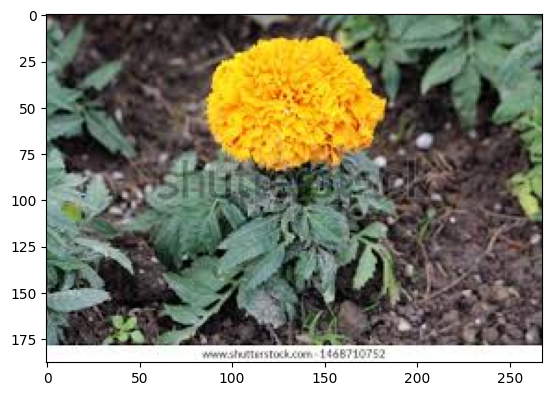

In [23]:
plt.imshow(x)

In [89]:
def evaluate_model(model, test_loader,loss_fn):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for img, label in test_loader:
            output = model(img)
            label = label.view(-1, 1)
            loss = loss_fn(output, label)
            total_loss += loss.item()

            predicted = (output > 0).float()
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

    average_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples
    return average_loss, accuracy


In [27]:
def display_predictions(model, data_loader, class_labels=["Marigold", "Sunflower"] , device="cpu"):

    model.eval()
    fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(18, 18))
    axes = axes.flatten()

    img_counter = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device).long()

        with torch.no_grad():
            outputs = model(images)
            # print(outputs)
            preds = (outputs > 0.0).float()
            # print(preds)

        for j in range(len(images)):
            if img_counter >= len(axes):
                break

            ax = axes[img_counter]
            img = images[j].cpu().clone()

            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            img = img[..., ::-1]

            ax.imshow(img)
            ax.set_title(f"Pred: {class_labels[int(preds[j].item())]}\nTrue: {class_labels[int(labels[j].item())]}")
            ax.axis("off")

            img_counter += 1

        if img_counter >= len(axes):
            break

    plt.tight_layout()
    plt.show()

In [28]:
import time
import numpy as np
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def train_model(model, train_loader, test_loader, log_dir, chkpt_path):
    # Optimizer and loss function
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
    loss_fn = nn.BCEWithLogitsLoss()

    # Early stopping variables
    min_loss = float('inf')
    patience = 5
    iteration = 0

    # Logging variables
    training_losses = []
    training_accuracies = []
    testing_losses = []
    testing_accuracies = []

    # Timer
    total_start_time = time.time()

    # TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)

    # Training loop
    for epoch in range(100):
        if patience == 0:
            print(f"Early stopping at epoch {epoch}")
            break

        # Training phase
        model.train()
        epoch_train_loss = 0.0
        epoch_train_correct = 0
        epoch_train_samples = 0

        with tqdm(train_loader, desc=f'Epoch {epoch + 1}', unit='batch', leave=False) as pbar:
            for img, label in pbar:
                img, label = img, label.view(-1, 1)

                optimizer.zero_grad()
                output = model(img)

                loss = loss_fn(output, label)
                loss.backward()
                optimizer.step()

                # Predictions and accuracy
                predicted = (output > 0.5).float()
                correct = (predicted == label).sum().item()

                # Update stats
                epoch_train_loss += loss.item() * img.size(0)  # Sum the loss
                epoch_train_correct += correct
                epoch_train_samples += img.size(0)

                # Log training metrics
                writer.add_scalar('Training Loss', loss.item(), iteration)
                writer.add_scalar('Training Accuracy', correct / img.size(0), iteration)

                pbar.set_postfix(loss=loss.item(), accuracy=correct / img.size(0))
                iteration += 1

        # Calculate training metrics for the epoch
        avg_train_loss = epoch_train_loss / epoch_train_samples
        avg_train_accuracy = epoch_train_correct / epoch_train_samples
        training_losses.append(avg_train_loss)
        training_accuracies.append(avg_train_accuracy)

        # Testing phase
        model.eval()
        epoch_test_loss = 0.0
        epoch_test_correct = 0
        epoch_test_samples = 0

        with torch.no_grad():
            for img, label in test_loader:
                img, label = img, label.view(-1, 1)
                output = model(img)

                loss = loss_fn(output, label)

                predicted = (output > 0.5).float()
                correct = (predicted == label).sum().item()

                # Update stats
                epoch_test_loss += loss.item() * img.size(0)  # Sum the loss
                epoch_test_correct += correct
                epoch_test_samples += img.size(0)

        # Calculate testing metrics for the epoch
        avg_test_loss = epoch_test_loss / epoch_test_samples
        avg_test_accuracy = epoch_test_correct / epoch_test_samples
        testing_losses.append(avg_test_loss)
        testing_accuracies.append(avg_test_accuracy)

        # Log testing metrics
        writer.add_scalar('Test Loss', avg_test_loss, epoch)
        writer.add_scalar('Test Accuracy', avg_test_accuracy, epoch)

        # Save the model if it has the lowest test loss
        if avg_test_loss < min_loss:
            min_loss = avg_test_loss
            patience = 5  # Reset patience
            torch.save(model.state_dict(), chkpt_path)
        else:
            patience -= 1  # Decrease patience if no improvement

        # Print epoch summary
        print(f"Epoch {epoch + 1}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}, "
              f"Patience Remaining: {patience}")

    # Calculate total training time
    total_training_time = time.time() - total_start_time

    # Return final metrics
    return total_training_time, np.mean(training_losses), np.mean(training_accuracies), np.mean(testing_accuracies)


In [29]:
train_dataset = flowerDataset(train)
test_dataset = flowerDataset(test)

train_loader = DataLoader(train_dataset,batch_size=8)
test_loader = DataLoader(test_dataset,batch_size=8)

$<----------------------MLP----------------------->$

In [11]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

Using device: cpu


In [30]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_size = 224 * 224 * 3  # Flattened input size
        self.output_size = 1 #2 # Binary classification
        self.model = nn.Sequential(
            nn.Flatten(),  # Flatten input image
            nn.Linear(self.input_size, 768),  # First layer with 1024 units
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(768, 512),  # Second layer with 512 units
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(512, 256),  # Third layer with 256 units
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(256, 128),   # Fourth layer with 128 units
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(128, self.output_size)
        )

    def forward(self, x):
        return self.model(x)


In [31]:
mlp_model = MLP()
# mlp_model = MLP().to(device)

In [32]:
train_time_MLP,train_loss_MLP,train_acc_MLP,test_acc_MLP = train_model(mlp_model,train_loader=train_loader,test_loader=test_loader,log_dir='./logs_MLP',chkpt_path='MLP.pth')

Epoch 1: Train Loss: 0.6941, Train Accuracy: 0.5000, Test Loss: 0.6890, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 2: Train Loss: 0.6897, Train Accuracy: 0.5000, Test Loss: 0.6840, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 3: Train Loss: 0.6831, Train Accuracy: 0.5000, Test Loss: 0.6764, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 4: Train Loss: 0.6749, Train Accuracy: 0.5000, Test Loss: 0.6663, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 5: Train Loss: 0.6635, Train Accuracy: 0.5000, Test Loss: 0.6537, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 6: Train Loss: 0.6482, Train Accuracy: 0.5000, Test Loss: 0.6375, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 7: Train Loss: 0.6274, Train Accuracy: 0.5563, Test Loss: 0.6167, Test Accuracy: 0.5250, Patience Remaining: 5


Epoch 8: Train Loss: 0.6037, Train Accuracy: 0.6250, Test Loss: 0.5974, Test Accuracy: 0.6250, Patience Remaining: 5


Epoch 9: Train Loss: 0.5790, Train Accuracy: 0.6813, Test Loss: 0.5937, Test Accuracy: 0.6250, Patience Remaining: 5


Epoch 10: Train Loss: 0.5550, Train Accuracy: 0.6937, Test Loss: 0.6005, Test Accuracy: 0.6250, Patience Remaining: 4


Epoch 11: Train Loss: 0.5265, Train Accuracy: 0.7188, Test Loss: 0.6282, Test Accuracy: 0.6250, Patience Remaining: 3


Epoch 12: Train Loss: 0.4989, Train Accuracy: 0.7438, Test Loss: 0.6338, Test Accuracy: 0.6500, Patience Remaining: 2


Epoch 13: Train Loss: 0.4676, Train Accuracy: 0.7688, Test Loss: 0.6491, Test Accuracy: 0.6500, Patience Remaining: 1


Epoch 14: Train Loss: 0.4326, Train Accuracy: 0.8125, Test Loss: 0.4994, Test Accuracy: 0.7500, Patience Remaining: 5


Epoch 15: Train Loss: 0.5141, Train Accuracy: 0.7312, Test Loss: 0.5293, Test Accuracy: 0.7000, Patience Remaining: 4


Epoch 16: Train Loss: 0.4065, Train Accuracy: 0.8187, Test Loss: 0.5017, Test Accuracy: 0.7500, Patience Remaining: 3


Epoch 17: Train Loss: 0.3538, Train Accuracy: 0.8313, Test Loss: 0.6216, Test Accuracy: 0.7000, Patience Remaining: 2


Epoch 18: Train Loss: 0.3598, Train Accuracy: 0.8125, Test Loss: 0.4920, Test Accuracy: 0.7500, Patience Remaining: 5


Epoch 19: Train Loss: 0.2976, Train Accuracy: 0.8875, Test Loss: 0.7849, Test Accuracy: 0.6500, Patience Remaining: 4


Epoch 20: Train Loss: 0.3073, Train Accuracy: 0.8750, Test Loss: 0.9411, Test Accuracy: 0.6500, Patience Remaining: 3


Epoch 21: Train Loss: 0.3312, Train Accuracy: 0.8625, Test Loss: 1.0293, Test Accuracy: 0.5750, Patience Remaining: 2


Epoch 22: Train Loss: 0.2865, Train Accuracy: 0.8938, Test Loss: 0.8043, Test Accuracy: 0.6750, Patience Remaining: 1


Epoch 23: Train Loss: 0.3007, Train Accuracy: 0.8875, Test Loss: 0.8957, Test Accuracy: 0.6750, Patience Remaining: 0
Early stopping at epoch 23


In [33]:
Description_MLP =(mlp_model,train_time_MLP,train_loss_MLP,train_acc_MLP,test_acc_MLP)
print(Description_MLP)

(MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=768, bias=True)
    (2): ReLU()
    (3): Linear(in_features=768, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
), 322.2734463214874, 0.5000628293046485, 0.7043478260869567, 0.6173913043478262)


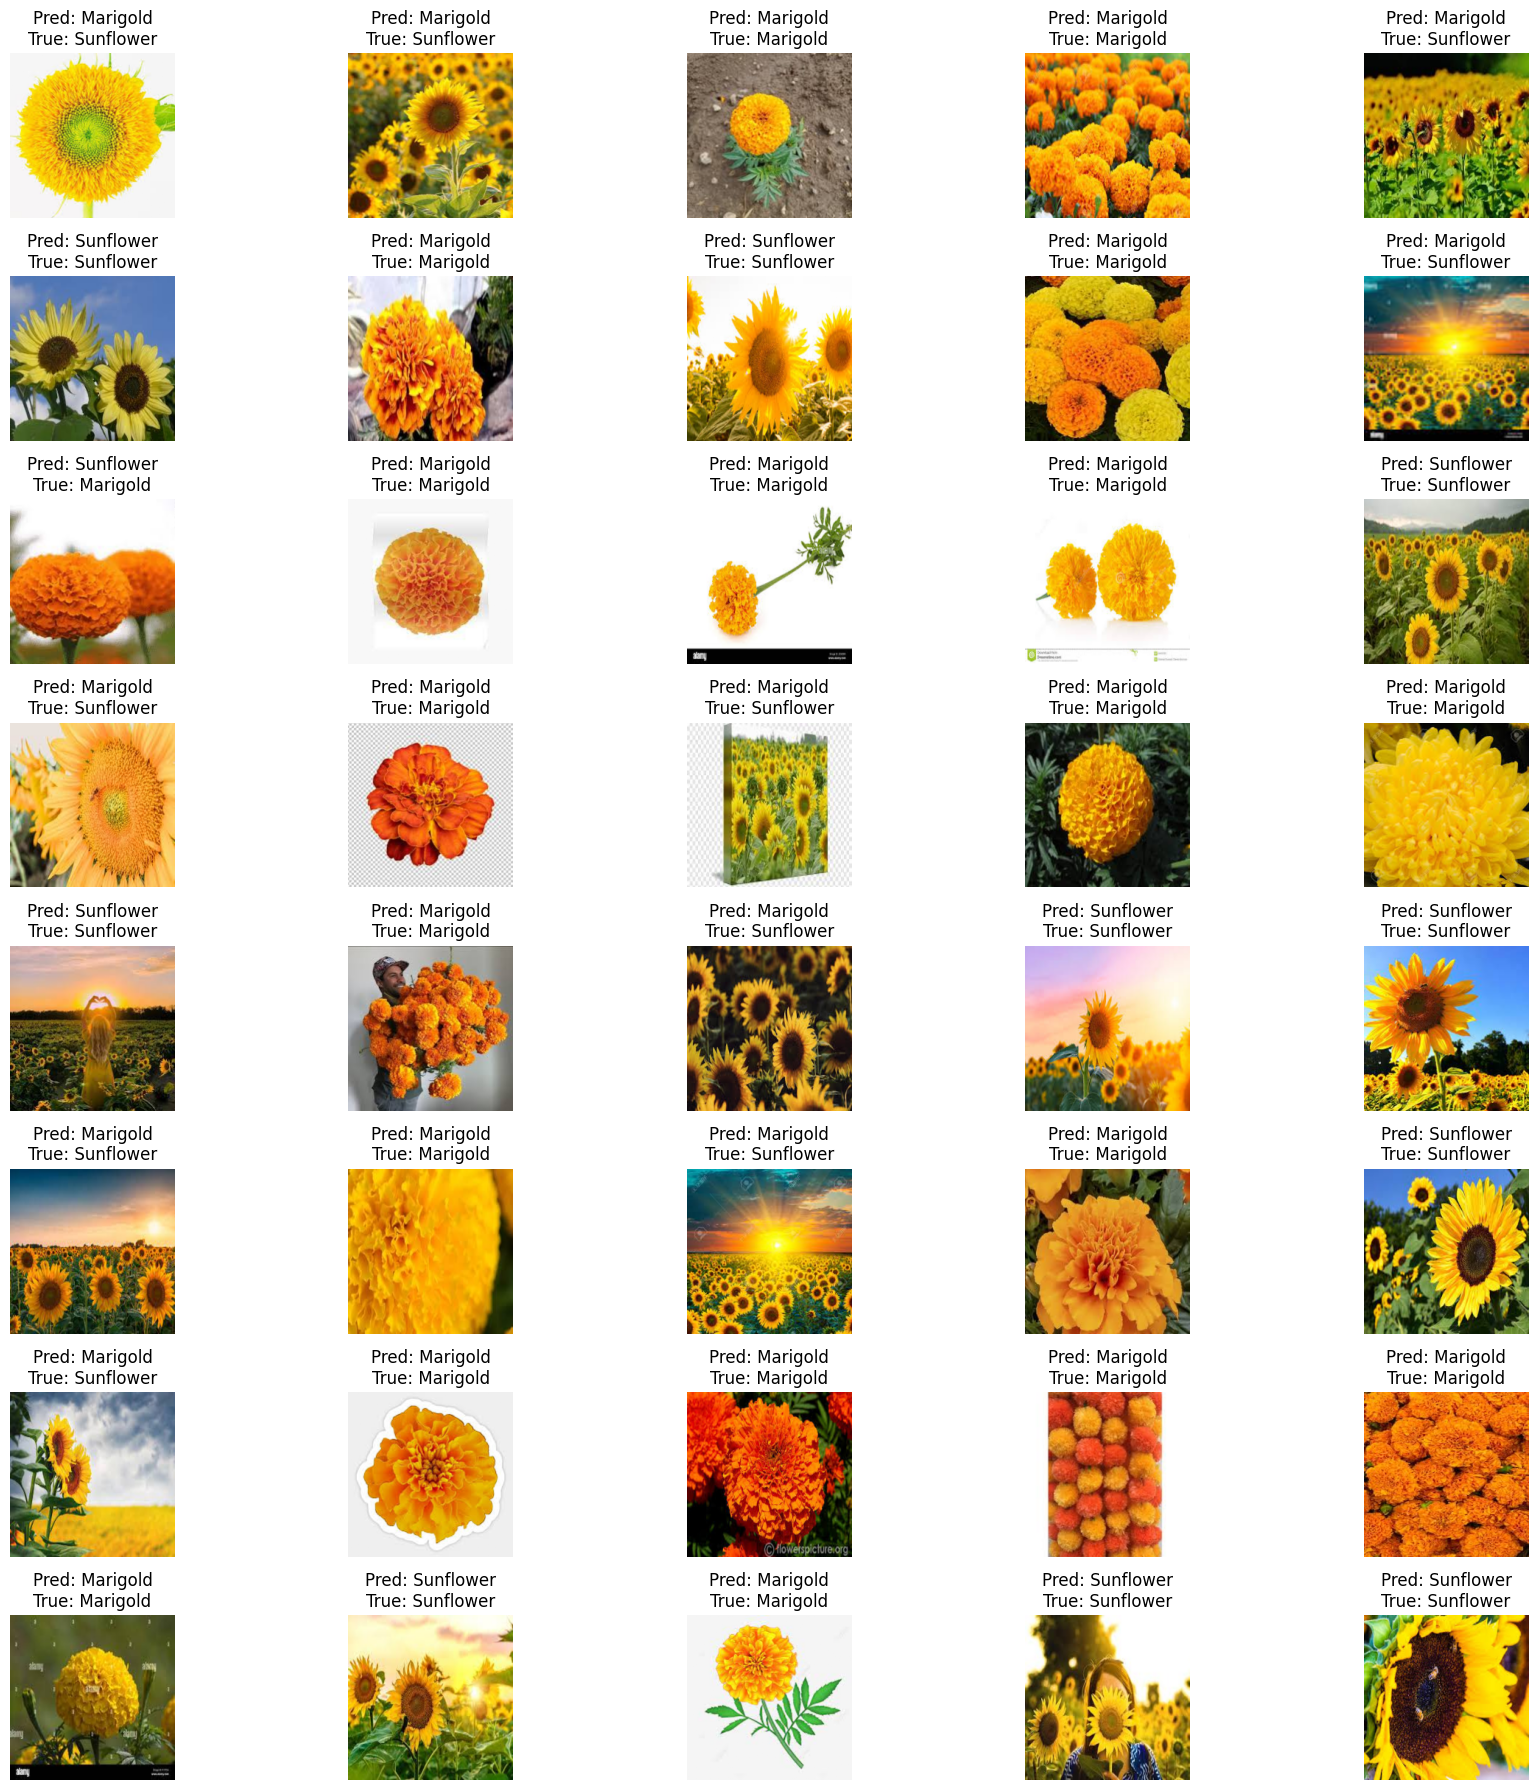

In [34]:
display_predictions(mlp_model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

$<--------------------Image\;generation\;and\;Testing----------------->$

In [35]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import accuracy_score


In [36]:
image_paths = [
    "class_a_easy.png",  # Marigold (easy)
    "class_a_hard.png",  # Marigold (hard)
    "class_b_easy.png",  # Sunflower (easy)
    "class_b_hard.png"   # Sunflower (hard)
]

labels = [0, 0, 1, 1]
names = ["marigold_easy", "marigold_hard", "sunflower_easy", "sunflower_hard"]

In [38]:
def preprocess_image(image_path, target_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")  # Ensure RGB format
    return transform(image).unsqueeze(0)

In [93]:
def evaluate_model_pytorch(model, images, labels, names):
    model.eval()  # Set model to evaluation mode
    predictions = []

    # Loop through images
    for i, image in enumerate(images):
        # with torch.no_grad():
        #     output = model(image)  # Forward pass
        #     print(output)
        #     prob = torch.sigmoid(output)  # Apply sigmoid for binary classification
        #     pred = (output > 0).float()  # Convert probabilities to binary labels (threshold = 0.5)
        #     predictions.append(pred.item())
        with torch.no_grad():
            output = model(image)  # Forward pass
            print(output)
            prob = torch.sigmoid(output)  # Apply sigmoid for binary classification
            pred = (prob > 0.5).float()  # Convert probabilities to binary labels (threshold = 0.5)
            predictions.append(pred.item())

        # with torch.no_grad():
        #     output = model(image)  # Forward pass
        #     prob = torch.sigmoid(output)  # Apply sigmoid for binary classification
        #     pred = (prob > 0.5).int()  # Convert probabilities to binary labels (threshold = 0.5)
        #     predictions.append(pred.item())

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)

    # Print results
    print(f"Model Accuracy: {accuracy * 100:.2f}%")
    for i, name in enumerate(names):
        predicted_label = "marigold" if predictions[i] == 0 else "sunflower"
        true_label = "marigold" if labels[i] == 0 else "sunflower"
        print(f"Image: {name}, Predicted: {predicted_label}, True: {true_label}")

    return accuracy


In [41]:
images = [preprocess_image(path) for path in image_paths]
# images

**$Evaluating\; MLP\:Model$**

In [94]:
# Evaluating all the model
evaluate_model_pytorch(mlp_model, images, labels, names)

tensor([[3.9516]])
tensor([[0.3190]])
tensor([[3.9118]])
tensor([[2.2407]])
Model Accuracy: 50.00%
Image: marigold_easy, Predicted: sunflower, True: marigold
Image: marigold_hard, Predicted: sunflower, True: marigold
Image: sunflower_easy, Predicted: sunflower, True: sunflower
Image: sunflower_hard, Predicted: sunflower, True: sunflower


0.5

**$Please\;Ingnore\;folowing \;part\;   Evaluating\; VGG \:block3\;Model$**

In [82]:
model_VGG_block3 = VGG(num_blocks=3)
model_VGG_block3.load_state_dict(torch.load('vgg_3.pth'))
# model_VGG_block3.eval()

<ipython-input-82-8923e37a3614>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_VGG_block3.load_state_dict(torch.load('vgg_3.pth'))


<All keys matched successfully>

In [95]:
evaluate_model_pytorch(model_VGG_block3, images, labels, names)

tensor([[2.3269]])
tensor([[2.0877]])
tensor([[2.2832]])
tensor([[1.9078]])
Model Accuracy: 50.00%
Image: marigold_easy, Predicted: sunflower, True: marigold
Image: marigold_hard, Predicted: sunflower, True: marigold
Image: sunflower_easy, Predicted: sunflower, True: sunflower
Image: sunflower_hard, Predicted: sunflower, True: sunflower


0.5

**$Evaluating\; VGG \:block1\;Model$**

In [84]:
model_VGG_block1 = VGG(num_blocks=1)
model_VGG_block1.load_state_dict(torch.load('vgg_1.pth'))
# model_VGG_block1.eval()

<ipython-input-84-609297243d51>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_VGG_block1.load_state_dict(torch.load('vgg_1.pth'))


<All keys matched successfully>

In [85]:
evaluate_model_pytorch(model_VGG_block1, images, labels, names)

tensor([[3.8795]])
tensor([[1.8707]])
tensor([[0.9374]])
tensor([[6.2877]])
Model Accuracy: 50.00%
Image: marigold_easy, Predicted: sunflower, True: marigold
Image: marigold_hard, Predicted: sunflower, True: marigold
Image: sunflower_easy, Predicted: sunflower, True: sunflower
Image: sunflower_hard, Predicted: sunflower, True: sunflower


0.5

**$Evaluating\; VGG \:block\;3\;Data\;augmented\;Model$**

In [60]:
model_VGG_block_da = VGG(num_blocks=3)
model_VGG_block_da.load_state_dict(torch.load('vgg_3_augment.pth'))
# model_VGG_block_da.eval()

<ipython-input-60-fdfd949113a8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_VGG_block_da.load_state_dict(torch.load('vgg_3_augment.pth'))


<All keys matched successfully>

In [86]:
evaluate_model_pytorch(model_VGG_block_da, images, labels, names)

tensor([[2.2974]])
tensor([[1.5517]])
tensor([[0.4509]])
tensor([[1.9012]])
Model Accuracy: 50.00%
Image: marigold_easy, Predicted: sunflower, True: marigold
Image: marigold_hard, Predicted: sunflower, True: marigold
Image: sunflower_easy, Predicted: sunflower, True: sunflower
Image: sunflower_hard, Predicted: sunflower, True: sunflower


0.5

**$Evaluating\; VGG \;16\;all\;tuned\;Model$**

In [87]:
vgg_16_finetuned_all = models.vgg16()
vgg_16_finetuned_all.classifier[6] = nn.Linear(vgg_16_finetuned_all.classifier[6].in_features,1)
vgg_16_finetuned_all.load_state_dict(torch.load('vgg_16_finetuned_all.pth'))

<ipython-input-87-dda713a7c0b7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_16_finetuned_all.load_state_dict(torch.load('vgg_16_finetuned_all.pth'))


<All keys matched successfully>

In [88]:
evaluate_model_pytorch(vgg_16_finetuned_all, images, labels, names)

tensor([[-6.9711]])
tensor([[-0.0408]])
tensor([[10.5343]])
tensor([[12.3774]])
Model Accuracy: 100.00%
Image: marigold_easy, Predicted: marigold, True: marigold
Image: marigold_hard, Predicted: marigold, True: marigold
Image: sunflower_easy, Predicted: sunflower, True: sunflower
Image: sunflower_hard, Predicted: sunflower, True: sunflower


1.0

**$Evaluating\; VGG \;16\;FC\;tuned\;Model$**

In [69]:
vgg_16_finetuned_MLP = models.vgg16()
vgg_16_finetuned_MLP.classifier[6] = nn.Linear(vgg_16_finetuned_MLP.classifier[6].in_features,1)
vgg_16_finetuned_MLP.load_state_dict(torch.load('vgg_16_finetuned_MLP.pth'))

<ipython-input-69-12e1ed984b50>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_16_finetuned_MLP.load_state_dict(torch.load('vgg_16_finetuned_MLP.pth'))


<All keys matched successfully>

In [71]:
evaluate_model_pytorch(vgg_16_finetuned_MLP, images, labels, names)

tensor([[0.9172]])
tensor([[2.5466]])
tensor([[8.7405]])
tensor([[7.6523]])
Model Accuracy: 50.00%
Image: marigold_easy, Predicted: sunflower, True: marigold
Image: marigold_hard, Predicted: sunflower, True: marigold
Image: sunflower_easy, Predicted: sunflower, True: sunflower
Image: sunflower_hard, Predicted: sunflower, True: sunflower


0.5

$<------------END------------>$